In [1]:
%pylab inline

import os
from styles.paper import *
from styles.colors import *
from styles.labels import *
from tools.photometry import integrated_flux as flux

Populating the interactive namespace from numpy and matplotlib


In [2]:
#read SED list
idir = os.path.expandvars("$phd/inputs/tta_cb13/set_cb13/")
flist = sorted([file for root, subs, files in os.walk(idir) for file in files if "nd" not in file and file.endswith(".sed")])

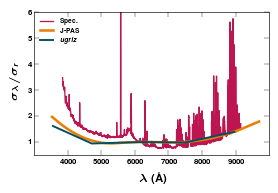

In [3]:
#read Spec. sigma
wl_spec, sigma_spec = loadtxt("../inputs/SDSS_spec_error_original.txt", unpack=True)
sigma_spec *= 1e-17

#read J-PAS filters
jpas = open("../inputs/JPAS_filters.txt").readlines()

mask = [False if item.startswith("#") else True for item in jpas]
jpas_res = []
for i in xrange(mask.count(False)):
    try:
        ini = mask.index(False); mask.remove(False)
        fin = mask.index(False)
        
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:fin+1+i]]))
        
    except ValueError:
        jpas_res.append(np.array([eval(item.replace("  ", ",")) for item in jpas[ini+1+i:]]))
#read J-PAS sigma
wl_jpas, sigma_jpas = loadtxt("../inputs/JPAS_sigma.txt")

#read ugriz filters
sdss_res = loadtxt("../inputs/SDSS_filters.txt")

sdss_res = [
    sdss_res[:47],
    sdss_res[47:47+89],
    sdss_res[47+89:47+89+75],
    sdss_res[47+89+75:47+89+75+89],
    sdss_res[47+89+75+89:]
]
#read ugriz sigma
wl_sdss, sigma_sdss = loadtxt("../inputs/SDSS_sigma.txt")

#find normalization wavelength
iwl_spec_norm = argmin(abs(wl_sdss[2]-wl_spec))
iwl_jpas_norm = argmin(abs(wl_sdss[2]-wl_jpas))
#normalize sigmas at r
sigma_spec /= sigma_spec[iwl_spec_norm]
sigma_jpas /= sigma_jpas[iwl_jpas_norm]*3 #reshape J-PAS sigma to reduce effect of sky emission in the red region
sigma_jpas += 1-sigma_jpas[iwl_jpas_norm] #re-normlize at r
sigma_sdss /= sigma_sdss[2]

fig = figure(figsize=(3.3,2.0))
ax = fig.add_subplot(111)

ax.plot(wl_spec, sigma_spec, "-", color=seds["spec"], lw=1.0, label=r"\bf Spec.")
ax.plot(wl_jpas, sigma_jpas, "-", color=seds["jpas"], lw=2.0, label=r"\bf J-PAS")
ax.plot(wl_sdss, sigma_sdss, "-", color=samples["cold"], lw=1.5, label=r"\bf $ugriz$")
ax.legend(loc=0)
ax.set_xlabel(r"\bf $\lambda$ (\AA)")
ax.set_ylabel(r"\bf $\sigma_\lambda/\sigma_r$")
ax.set_ylim(0.5,6.0)
ax.xaxis.set_major_locator(MaxNLocator(nbins=8, prune="both"))

savefig("{}/sigma_spectrum".format(os.path.expandvars("$HOME/Documents/Publications/photofit_near_paper")))

In [4]:
random.seed(0)

hdr = "%10s %12s %12s"%tuple("wavelength flux sigma".split())
fmt = "%12.2f %12.4e %12.4e"

snr_spec, snr_jpas, snr_sdss = 20.0, 45.0, 140.0
N = 20
for fname in flist:
    name = fname.replace("_z0p00.sed", "")
    sed_hr = loadtxt(os.path.join(idir, fname))
    
    wl_hr, fl_hr = sed_hr[:, [0,2]].T
    sed_hr = sed_hr[:, [0,1]]
    
    fl_spec = interp(wl_spec, wl_hr, fl_hr)
    sg_spec = sigma_spec*fl_spec/snr_spec
    
    fl_jpas = array([flux(sed_hr, filt) for filt in jpas_res])
    sg_jpas = sigma_jpas*fl_jpas/snr_jpas
    
    fl_sdss = array([flux(sed_hr, filt) for filt in sdss_res])
    sg_sdss = sigma_sdss*fl_sdss/snr_sdss

#     savetxt("../inputs/tta_cb13/ssag/{0}.txt".format(name.split(".")[0]), column_stack((wl_hr, fl_hr)), fmt="%12.2f %12.4e", header="%10s %12s"%tuple("wavelength flux".split()))
    for i in xrange(N):
        fl_spec_noisy = fl_spec + random.randn(fl_spec.size)*sg_spec
        fl_jpas_noisy = fl_jpas + random.randn(fl_jpas.size)*sg_jpas
        fl_sdss_noisy = fl_sdss + random.randn(fl_sdss.size)*sg_sdss

#         savetxt("../inputs/tta_cb13/spec/{0}_SPEC_{1:03d}.txt".format(name.split(".")[0], i+1), column_stack((wl_spec, fl_spec_noisy, sg_spec)), fmt=fmt, header=hdr)
#         savetxt("../inputs/tta_cb13/jpas/{0}_JPAS_{1:03d}.txt".format(name.split(".")[0], i+1), column_stack((wl_jpas, fl_jpas_noisy, sg_jpas)), fmt=fmt, header=hdr)
#         savetxt("../inputs/tta_cb13/sdss/{0}_SDSS_{1:03d}.txt".format(name.split(".")[0], i+1), column_stack((wl_sdss, fl_sdss_noisy, sg_sdss)), fmt=fmt, header=hdr)

#     figure()
#     title(name)
#     plot(wl_spec, fl_spec_noisy, "-", color="0.7", lw=0.7)
#     plot(wl_hr, fl_hr, "-k", lw=0.7, color="k")
#     plot(wl_jpas, fl_jpas_noisy, "o", mfc="none", mew=1.5, ms=4, mec="r")
#     plot(wl_sdss, fl_sdss_noisy, "^", mfc="none", mew=1, ms=14, mec="b")

#     xlim(3200, 9800)
#     xlabel("Wavelength")
#     ylabel("Flux")
#     savefig("img/{}.png".format(fname.rstrip(".sed")), bbox_inches="tight")

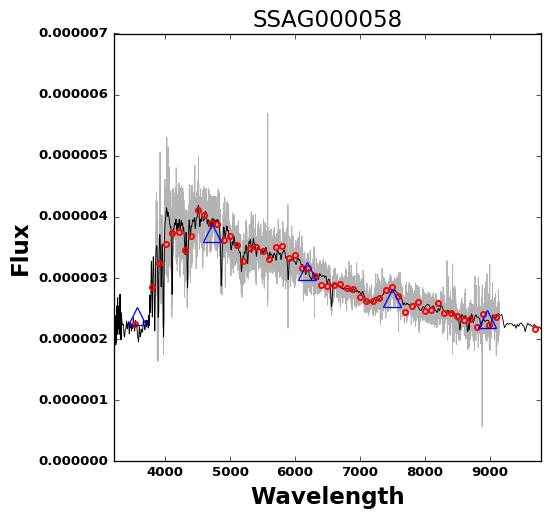

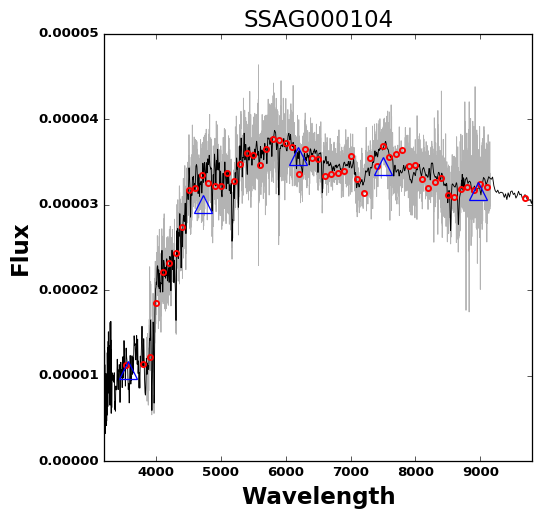

In [12]:
random.seed(0)

hdr = "%10s %12s %12s"%tuple("wavelength flux sigma".split())
fmt = "%12.2f %12.4e %12.4e"

snr_spec, snr_jpas, snr_sdss = 20.0, 45.0, 140.0
N = 100
for fname in flist:
    name = fname.replace("_z0p00.sed", "")
    sed_hr = loadtxt(os.path.join(idir, fname))
    if not name.endswith("58") and not name.endswith("104"): continue
    
    wl_hr, fl_hr = sed_hr[:, [0,2]].T
    sed_hr = sed_hr[:, [0,1]]
    
    fl_spec = interp(wl_spec, wl_hr, fl_hr)
    sg_spec = sigma_spec*fl_spec/snr_spec
    
    fl_jpas = array([flux(sed_hr, filt) for filt in jpas_res])
    sg_jpas = sigma_jpas*fl_jpas/snr_jpas
    
    fl_sdss = array([flux(sed_hr, filt) for filt in sdss_res])
    sg_sdss = sigma_sdss*fl_sdss/snr_sdss

    savetxt("data/TTAChiTests/ssag/{0}.txt".format(name.split(".")[0]), column_stack((wl_hr, fl_hr)), fmt="%12.2f %12.4e", header="%10s %12s"%tuple("wavelength flux".split()))
    for i in xrange(N):
        fl_spec_noisy = fl_spec + random.randn(fl_spec.size)*sg_spec
        fl_jpas_noisy = fl_jpas + random.randn(fl_jpas.size)*sg_jpas
        fl_sdss_noisy = fl_sdss + random.randn(fl_sdss.size)*sg_sdss

        savetxt("data/TTAChiTests/spec/{0}_SPEC_{1:03d}.txt".format(name.split(".")[0], i+1), column_stack((wl_spec, fl_spec_noisy, sg_spec)), fmt=fmt, header=hdr)
        savetxt("data/TTAChiTests/jpas/{0}_JPAS_{1:03d}.txt".format(name.split(".")[0], i+1), column_stack((wl_jpas, fl_jpas_noisy, sg_jpas)), fmt=fmt, header=hdr)
        savetxt("data/TTAChiTests/sdss/{0}_SDSS_{1:03d}.txt".format(name.split(".")[0], i+1), column_stack((wl_sdss, fl_sdss_noisy, sg_sdss)), fmt=fmt, header=hdr)

    figure()
    title(name)
    plot(wl_spec, fl_spec_noisy, "-", color="0.7", lw=0.7)
    plot(wl_hr, fl_hr, "-k", lw=0.7, color="k")
    plot(wl_jpas, fl_jpas_noisy, "o", mfc="none", mew=1.5, ms=4, mec="r")
    plot(wl_sdss, fl_sdss_noisy, "^", mfc="none", mew=1, ms=14, mec="b")

    xlim(3200, 9800)
    xlabel("Wavelength")
    ylabel("Flux")
    #savefig("img/{}.png".format(fname.rstrip(".sed")), bbox_inches="tight")